#**PROBLEMA DE NEGOCIO**


---




##Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?

#**1. Configuración del Ambiente**


---




In [3]:
!pip install geobr
import geobr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import requests
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, inspect, text
global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.3
    Uninstalling shapely-2.0.3:
      Successfully uninstalled shapely-2.0.3
  Attempting uninstall: lxml
    Found existing installation: lxml 4.9.4
    Uninstalling lxml-4.9.4:
      Successfully uninstalled lxml-4.9.4
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [4]:
df_itens_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/itens_pedidos.csv')
df_itens_pedidos.head()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0


In [5]:
df_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/pedidos.csv')
df_pedidos.head()

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [6]:
df_productos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/productos.csv')
df_productos.head()

,producto_id,producto,precio,marca,sku,condicion
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297.0,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612.0,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482.0,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248.0,Usado


In [7]:
df_vendedores = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/vendedores.csv')
df_vendedores

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca
5,6,Unknown


In [8]:
df_pedidos[df_pedidos['vendedor_id']==6]

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780


In [9]:
df_productos[df_productos['producto_id']==41518]

,producto_id,producto,precio,marca,sku,condicion
204,41518,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta


In [10]:
df_itens_pedidos[df_itens_pedidos['pedido_id']==341]

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,1,41518,341,3,260,780,BR-BA,156.0


####**Nota:** Como dato podemos observar que hay un vendedor desconocido en la BDD y que realizo solo una venta del producto Calca Jeans Basica con un valor total de 780R$

In [11]:
#Eliminamos al cliente desconocido
df_vendedores.drop(df_vendedores[df_vendedores['vendedor_id'] == 6].index, inplace=True)
df_itens_pedidos.drop(df_itens_pedidos[df_itens_pedidos['pedido_id'] == 341].index, inplace=True)
df_productos.drop(df_productos[df_productos['producto_id']==41518].index, inplace=True)
df_pedidos.drop(df_pedidos[df_pedidos['vendedor_id']==6].index, inplace=True)

##**2.2 Tratamiento de Datos**

In [12]:
print(df_itens_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 1 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24526 non-null  int64  
 1   producto_id     24526 non-null  int64  
 2   pedido_id       24526 non-null  int64  
 3   cantidad        24526 non-null  int64  
 4   valor_unitario  24526 non-null  int64  
 5   valor_total     24526 non-null  int64  
 6   ciudad          24526 non-null  object 
 7   costo_envio     24526 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 1 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24526 non-null  int64 
 1   producto_id   24526 non-null  int64 
 2   vendedor_id   24526 non-null  int64 
 3   fecha_compra  24526 non-null  object
 

In [13]:
#Verficar Nulos

In [14]:
df_itens_pedidos.isna().sum().sort_values(ascending = False)

id_recibo         0
producto_id       0
pedido_id         0
cantidad          0
valor_unitario    0
valor_total       0
ciudad            0
costo_envio       0
dtype: int64

In [15]:
df_pedidos.isna().sum().sort_values(ascending = False)

pedido_id       0
producto_id     0
vendedor_id     0
fecha_compra    0
total           0
dtype: int64

In [16]:
df_productos.isna().sum().sort_values(ascending = False)

producto       2
sku            2
producto_id    0
precio         0
marca          0
condicion      0
dtype: int64

In [17]:
df_vendedores.isna().sum().sort_values(ascending = False)

vendedor_id        0
nombre_vendedor    0
dtype: int64

In [18]:
#Verificar Duplicados por filas

In [19]:
df_itens_pedidos[df_itens_pedidos.duplicated()].sum()

id_recibo           0
producto_id         0
pedido_id           0
cantidad            0
valor_unitario      0
valor_total         0
ciudad              0
costo_envio       0.0
dtype: object

In [20]:
df_pedidos[df_pedidos.duplicated()].sum()

pedido_id       0
producto_id     0
vendedor_id     0
fecha_compra    0
total           0
dtype: object

In [21]:
df_productos[df_productos.duplicated()].sum()

producto_id      0
producto         0
precio           0
marca            0
sku            0.0
condicion        0
dtype: object

In [22]:
df_vendedores[df_vendedores.duplicated()].sum()

vendedor_id        0
nombre_vendedor    0
dtype: object

In [23]:
#Valores duplicados por la columna (clave primaria)

In [24]:
duplicados_por_columna = {}
for columna in df_itens_pedidos.columns:
    duplicados_por_columna[columna] = df_itens_pedidos[columna].duplicated().sum()

print("Cantidad de duplicados por columna:")
print(duplicados_por_columna)

Cantidad de duplicados por columna:
{'id_recibo': 0, 'producto_id': 24321, 'pedido_id': 0, 'cantidad': 24520, 'valor_unitario': 24441, 'valor_total': 24172, 'ciudad': 24499, 'costo_envio': 24172}


In [25]:
duplicados_por_columna = {}
for columna in df_pedidos.columns:
    duplicados_por_columna[columna] = df_pedidos[columna].duplicated().sum()

print("Cantidad de duplicados por columna:")
print(duplicados_por_columna)

Cantidad de duplicados por columna:
{'pedido_id': 0, 'producto_id': 24321, 'vendedor_id': 24521, 'fecha_compra': 23746, 'total': 24172}


In [26]:
duplicados_por_columna = {}
for columna in df_productos.columns:
    duplicados_por_columna[columna] = df_productos[columna].duplicated().sum()

print("Cantidad de duplicados por columna:")
print(duplicados_por_columna)

Cantidad de duplicados por columna:
{'producto_id': 0, 'producto': 5, 'precio': 121, 'marca': 89, 'sku': 1, 'condicion': 203}


In [27]:
duplicados_columna = df_productos['producto'][df_productos['producto'].duplicated(keep=False)].value_counts()
print("Duplicados en la columna 'producto':")
print(duplicados_columna)

Duplicados en la columna 'producto':
producto
Calca Alfaiataria Preta    2
Calca Jeans Costuras       2
Saia Pregas Preta          2
Vestido Recortes Cores     2
Name: count, dtype: int64


In [28]:
df_productos[df_productos['producto'] == 'Calca Alfaiataria Preta']

,producto_id,producto,precio,marca,sku,condicion
3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
26,11218,Calca Alfaiataria Preta,250,Le Lis Blanc,952813.0,Usado


In [29]:
duplicados_por_columna = {}
for columna in df_vendedores.columns:
    duplicados_por_columna[columna] = df_vendedores[columna].duplicated().sum()

print("Cantidad de duplicados por columna:")
print(duplicados_por_columna)

Cantidad de duplicados por columna:
{'vendedor_id': 0, 'nombre_vendedor': 0}


#### Como podemos apreciar los dataframes en sus claves primarias no presenta duplicados, una observación hay en la tabla productos que tenemos repetidos en la columa 'Producto' lo cual nos indica que hay productos repetidos, pero sus claves primarias diferentes esto se debe a que luego de hacer una revisión más profunda, podemos observar que se diferencian por la marca y esto lo hace diferente y que varie su precio también.

In [30]:
df_productos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 206
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   producto_id  206 non-null    int64  
 1   producto     204 non-null    object 
 2   precio       206 non-null    int64  
 3   marca        206 non-null    object 
 4   sku          204 non-null    float64
 5   condicion    206 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 11.3+ KB


In [31]:
df_productos[df_productos.isnull().any(axis=1)]


,producto_id,producto,precio,marca,sku,condicion
205,41598,NaN,260,Banana Republic,NaN,Nuevo con etiqueta
206,32926,NaN,210,Limone By Jade Seba,NaN,Nuevo sin etiqueta


####Como podemos apreciar en la tabla productos tenemos dos valores nulos que pertenecen a la misma fila, procedemos a eliminarla.

In [32]:
def preprocesamiento():
  global df_itens_pedidos, df_pedidos, df_productos, df_vendedores
  #Eliminar Nulos
  df_itens_pedidos = df_itens_pedidos.dropna()
  df_pedidos = df_pedidos.dropna()
  df_productos = df_productos.dropna()
  df_vendedores = df_vendedores.dropna()
  #Eliminar los valores nulos de la tabla productos
  df_productos = df_productos.dropna(subset=['producto'])
  #Eliminar Duplicados
  df_itens_pedidos = df_itens_pedidos.drop_duplicates().reset_index(drop=True)
  df_pedidos = df_pedidos.drop_duplicates().reset_index(drop=True)
  df_productos = df_productos.drop_duplicates().reset_index(drop=True)
  df_vendedores = df_vendedores.drop_duplicates().reset_index(drop=True)
  #Cambiar tipo de dato en el dataframe Pedidos
  df_pedidos['fecha_compra'] = pd.to_datetime(df_pedidos['fecha_compra'], format='%Y-%m-%d')

In [33]:
preprocesamiento()
print(df_itens_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24526 non-null  int64  
 1   producto_id     24526 non-null  int64  
 2   pedido_id       24526 non-null  int64  
 3   cantidad        24526 non-null  int64  
 4   valor_unitario  24526 non-null  int64  
 5   valor_total     24526 non-null  int64  
 6   ciudad          24526 non-null  object 
 7   costo_envio     24526 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24526 non-null  int64         
 1   producto_id   24526 non-null  int64         
 2   vendedor_id   24526 non-null  int64         
 3 

##**2.3 Análisis Exploratorio (EDA)**

### **2.3.1.-Data Frame Pedidos**

In [34]:
df_pedidos.describe().T

,count,mean,min,25%,50%,75%,max,std
pedido_id,24526.0,69934.220501,1.0,34489.25,69946.0,105355.5,139993.0,40559.162177
producto_id,24526.0,44627.767961,2706.0,17258.0,42913.0,70673.0,100983.0,29348.41648
vendedor_id,24526.0,2.975658,1.0,2.0,3.0,4.0,5.0,1.442312
fecha_compra,24526,2020-04-02 12:37:24.018592512,2019-01-05 00:00:00,2019-11-12 00:00:00,2020-04-09 00:00:00,2020-09-21 00:00:00,2021-03-10 00:00:00,NaN
total,24526.0,1867.534453,45.0,520.0,1050.0,1920.0,39000.0,3379.743655


In [35]:
texto = """
Total de pedidos:
- Varía desde 45R$ hasta 39,000R$.
- La media del total de la compra es de aproximadamente 1050R$.
- La desviación estándar es de aproximadamente 3,380R$, lo que indica una variabilidad significativa en los montos totales de las compras.
"""
print(texto)


Total de pedidos:
- Varía desde 45R$ hasta 39,000R$.
- La media del total de la compra es de aproximadamente 1050R$.
- La desviación estándar es de aproximadamente 3,380R$, lo que indica una variabilidad significativa en los montos totales de las compras.



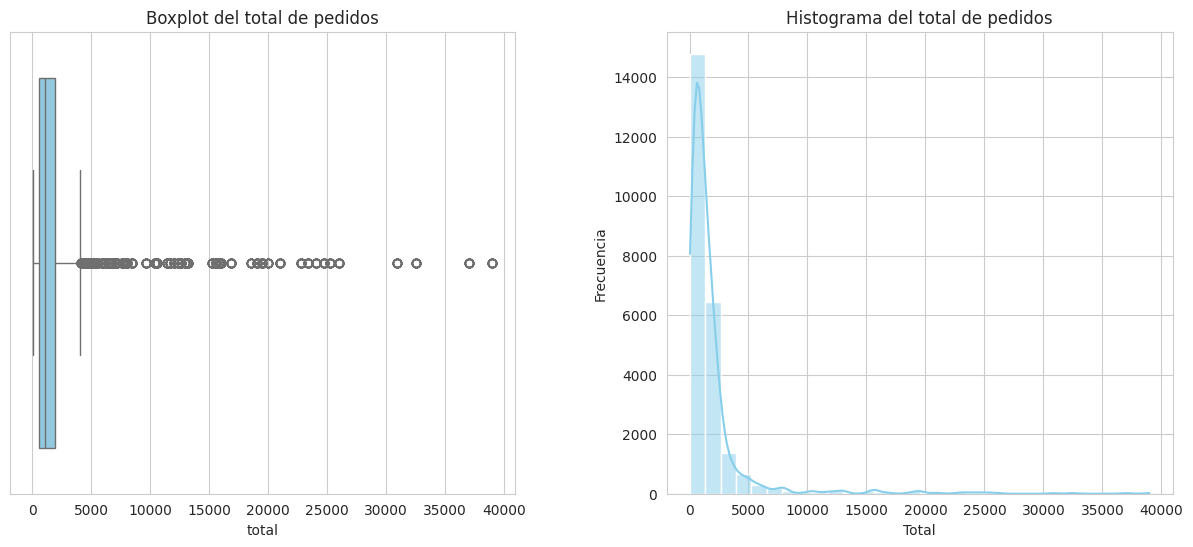

In [36]:
# Establecer el estilo de seaborn
sns.set_style("whitegrid")
# Crear la figura y los subplots
fig, (ax_box, ax_hist) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"width_ratios": (.50, .50)})
# Boxplot
sns.boxplot(x='total', data=df_pedidos, color='skyblue', ax=ax_box)
ax_box.set_title('Boxplot del total de pedidos')
# Histograma
sns.histplot(df_pedidos['total'], ax=ax_hist, color='skyblue', bins=30, kde=True)
ax_hist.set_ylabel('Frecuencia')
ax_hist.set_xlabel('Total')
ax_hist.set_title('Histograma del total de pedidos')
# Ajustar el espacio entre los subplots
plt.subplots_adjust(wspace=0.3)
# Mostrar la figura
plt.show()


In [37]:
'''
Como conclusión podemos ver que hay valores atipicos muy alejados de la media esto nos quiere decir que nuestros datos
tiene una variabilidad significativa, también podemos observar que en el histograma hay más concurrencia de pedidos con
un total de 0-4000 aproximadamente esto nos quiere decir que productos de menor precio aunque sean de costo menor, pero
generan una mayor rentabilidad en la cocurrencia de totales
'''

'\nComo conclusión podemos ver que hay valores atipicos muy alejados de la media esto nos quiere decir que nuestros datos\ntiene una variabilidad significativa, también podemos observar que en el histograma hay más concurrencia de pedidos con\nun total de 0-4000 aproximadamente esto nos quiere decir que productos de menor precio aunque sean de costo menor, pero\ngeneran una mayor rentabilidad en la cocurrencia de totales\n'

In [38]:
df_productos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   producto_id  204 non-null    int64  
 1   producto     204 non-null    object 
 2   precio       204 non-null    int64  
 3   marca        204 non-null    object 
 4   sku          204 non-null    float64
 5   condicion    204 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.7+ KB


In [39]:
df_productos.describe()

,producto_id,precio,sku
count,204.000000,204.000000,204.000000
mean,44819.470588,537.362745,304866.485294
std,29491.099629,845.627144,190577.742441
min,2706.000000,45.000000,101494.000000
25%,17311.250000,210.000000,221713.000000
50%,43376.500000,338.000000,264306.000000
75%,70708.000000,457.500000,304856.250000
max,100983.000000,6500.000000,952821.000000


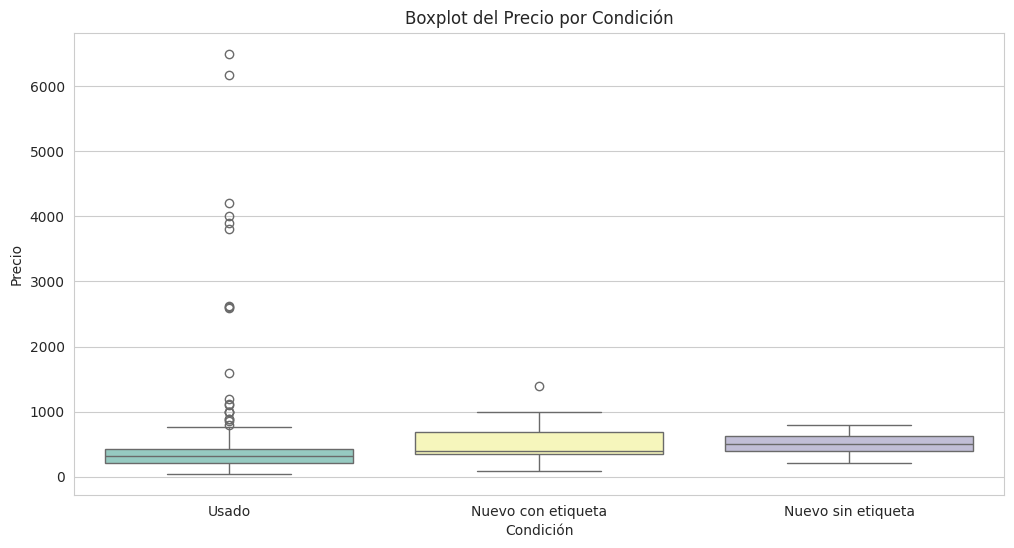

In [40]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=df_productos, x="condicion", y="precio", hue="condicion", palette="Set3")
ax.set(xlabel='Condición', ylabel='Precio')
ax.set_title("Boxplot del Precio por Condición")
plt.show()

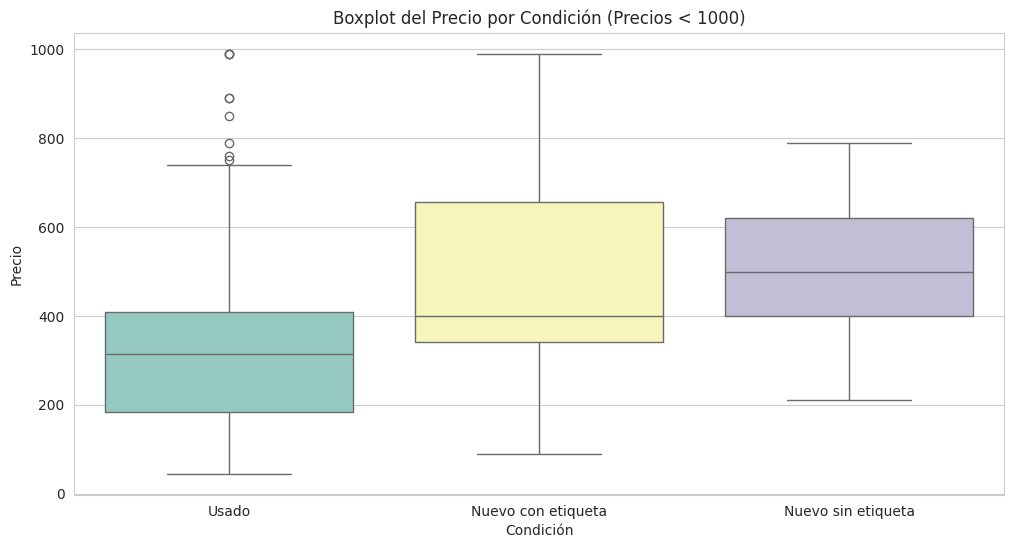

In [41]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=df_productos[df_productos['precio'] < 1000], x="condicion", y='precio', hue="condicion", palette="Set3")
ax.set(xlabel='Condición', ylabel='Precio')
ax.set_title("Boxplot del Precio por Condición (Precios < 1000)")
plt.show()

In [42]:
'''
Como podemos ver los productos que presentan una condición usados presenta una diferenciación significativa de precios comparado
con las otras dos condiciones, la media de los boxplot varian desde los 300 a 500 R$ respectivamente lo que significa que la mayoria de los productos
están ubicadas entre ese rango de precios
'''

'\nComo podemos ver los productos que presentan una condición usados presenta una diferenciación significativa de precios comparado\ncon las otras dos condiciones, la media de los boxplot varian desde los 300 a 500 R$ respectivamente lo que significa que la mayoria de los productos\nestán ubicadas entre ese rango de precios\n'

In [43]:
df_itens_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24526 non-null  int64  
 1   producto_id     24526 non-null  int64  
 2   pedido_id       24526 non-null  int64  
 3   cantidad        24526 non-null  int64  
 4   valor_unitario  24526 non-null  int64  
 5   valor_total     24526 non-null  int64  
 6   ciudad          24526 non-null  object 
 7   costo_envio     24526 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB


In [44]:
df_itens_pedidos.describe()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,costo_envio
count,24526.000000,24526.000000,24526.000000,24526.000000,24526.000000,24526.000000,24526.000000
mean,12405.920044,44627.767961,69934.220501,3.497146,535.699910,1867.534453,373.506891
std,7242.411995,29348.416480,40559.162177,1.706201,839.229313,3379.743655,675.948731
min,2.000000,2706.000000,1.000000,1.000000,45.000000,45.000000,9.000000
25%,6133.250000,17258.000000,34489.250000,2.000000,210.000000,520.000000,104.000000
50%,12264.500000,42913.000000,69946.000000,4.000000,336.000000,1050.000000,210.000000
75%,18689.750000,70673.000000,105355.500000,5.000000,450.000000,1920.000000,384.000000
max,25055.000000,100983.000000,139993.000000,6.000000,6500.000000,39000.000000,7800.000000


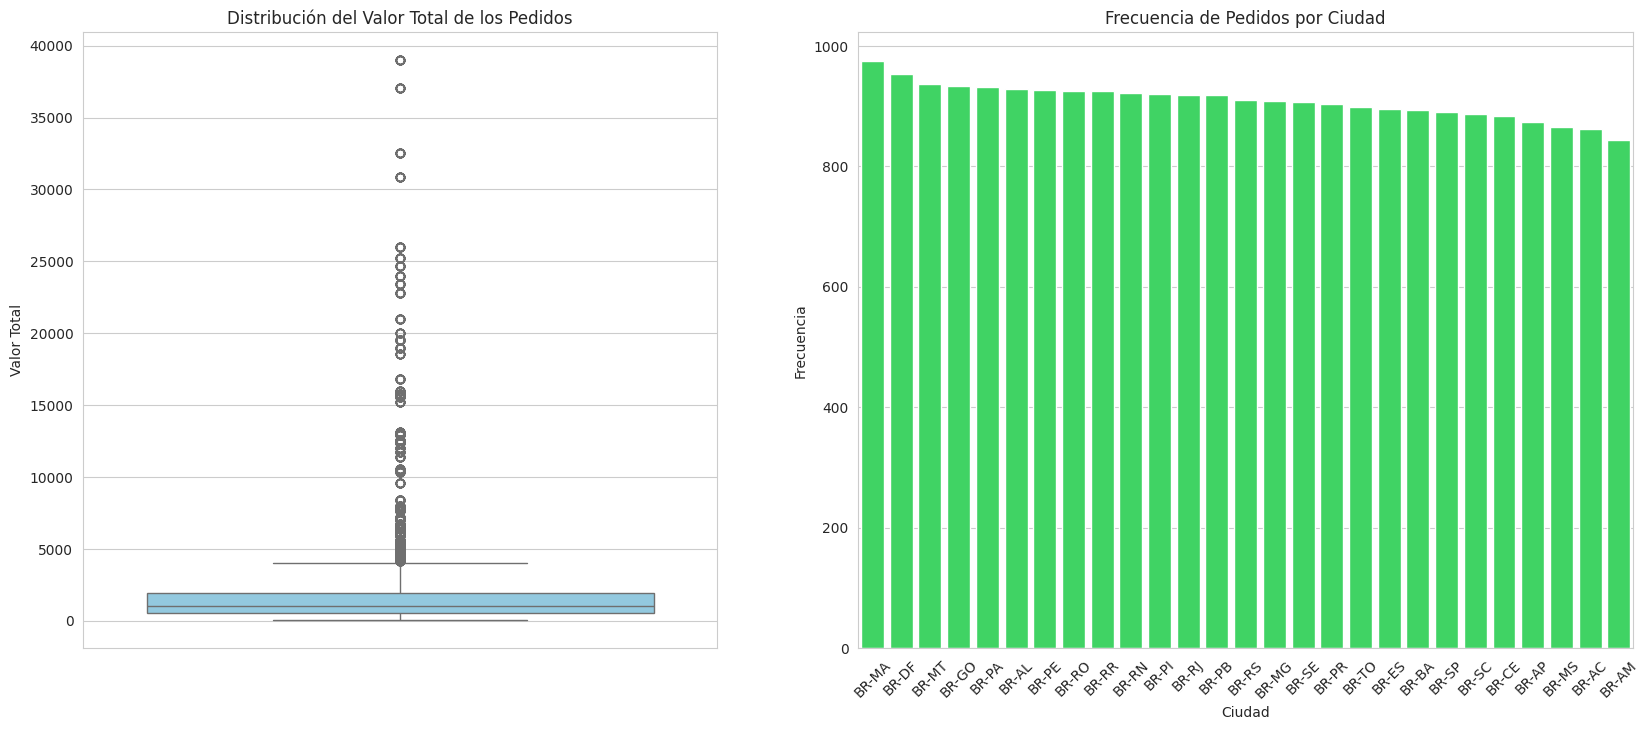

In [45]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={"width_ratios": (.45, .55)})

# Gráfico de caja (boxplot)
sns.boxplot(data=df_itens_pedidos, y="valor_total", ax=axes[0], color='skyblue')
axes[0].set_title('Distribución del Valor Total de los Pedidos')
axes[0].set_ylabel('Valor Total')

# Gráfico de barras para la frecuencia de ciudades
ciudad_freq = df_itens_pedidos["ciudad"].value_counts()
sns.barplot(x=ciudad_freq.index, y=ciudad_freq, ax=axes[1], color='#28EB57')
axes[1].set_title('Frecuencia de Pedidos por Ciudad')
axes[1].set_xlabel('Ciudad')
axes[1].set_ylabel('Frecuencia')
axes[1].tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje x

# Mostrar el gráfico
plt.show()


In [46]:
'''
Como podemos ver en el diagrama boxplot tenemos que presenta outlier muy alejados de la media esto nos quiere decir que nuestros datos
tiene una variabilidad significativa, esto corrobora al boxplot.
El histograma de ciudades muestra la frecuencia de pedidos por ciudad, revelando una distribución donde la mayoría de las ciudades
tienen una concurrencia moderada de pedidos, sin que ninguna ciudad tenga una presencia abrumadora en comparación con las demás.
'''

'\nComo podemos ver en el diagrama boxplot tenemos que presenta outlier muy alejados de la media esto nos quiere decir que nuestros datos\ntiene una variabilidad significativa, esto corrobora al boxplot.\nEl histograma de ciudades muestra la frecuencia de pedidos por ciudad, revelando una distribución donde la mayoría de las ciudades\ntienen una concurrencia moderada de pedidos, sin que ninguna ciudad tenga una presencia abrumadora en comparación con las demás.\n'

#**3. Preguntas y respuestas**


---




##**3.1 Creando el banco de datos**

In [47]:
#@title
def crear_conexion():
  global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database
  database=create_engine('sqlite:///:memory:')
  df_itens_pedidos.to_sql('itens_pedidos',database,index=False)
  df_pedidos.to_sql('pedidos',database,index=False)
  df_productos.to_sql('productos',database,index=False)
  df_vendedores.to_sql('vendedores',database,index=False)

In [48]:
crear_conexion()
inspector = inspect(database)
print('Tablas: ', inspector.get_table_names(), '\n')
print('Columnas de Tabla Itens_Pedidos:')
for column in inspector.get_columns('itens_pedidos'):
    print(column)
print('\n Columnas de Tabla Pedidos:')
for column in inspector.get_columns('pedidos'):
    print(column)
print('\n Columnas de Tabla Productos:')
for column in inspector.get_columns('productos'):
    print(column)
print('\n Columnas de Tabla Vendedores:')
for column in inspector.get_columns('vendedores'):
    print(column)
#database.dispose()

Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Itens_Pedidos:
{'name': 'id_recibo', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'producto_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'pedido_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'cantidad', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'valor_unitario', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'valor_total', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'ciudad', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'costo_envio', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}

 Columnas de Tabla Pedidos:
{'name': 'pedido_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'producto_id', 'type'

##**Pregunta 1: ¿Cual es el Top 5 productos más vendidos históricamente?**

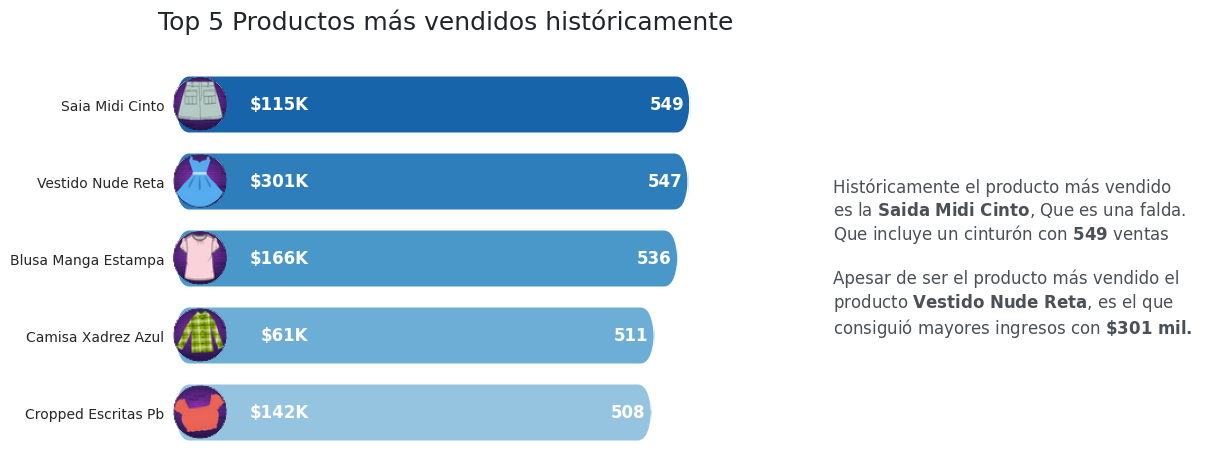

In [49]:
crear_conexion()
query = """
SELECT ip.producto_id,p.producto,p.marca,SUM(ip.valor_total) AS total_vendido,SUM(ip.cantidad) AS cantidad_vendida
FROM itens_pedidos  ip
INNER JOIN productos  p ON p.producto_id=ip.producto_id
GROUP BY ip.producto_id, p.producto, p.marca
ORDER BY cantidad_vendida DESC
LIMIT 5
"""
df=pd.read_sql(sql=text(query),con=database.connect())
database.dispose()
df['total_vendido'] = (df['total_vendido']/1000).apply(lambda x: f'${x:.0f}K')
image_path = [
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/falda.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/vestido.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/blusa.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/camisa.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/cropped.png']

plt.subplots(figsize=(7, 5))
colores_azules = plt.cm.Blues_r(np.linspace(0.2,0.6,len(df)))
ax = sns.barplot(x=df.cantidad_vendida/20, y=df.producto, orient='h', joinstyle='bevel')

new_patches = []
for patch, color, producto, cantidad_vendida, total_vendido, image_path in zip(ax.patches, colores_azules, df['producto'],df['cantidad_vendida'],df['total_vendido'],image_path):
    bb = patch.get_bbox()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.05,rounding_size=0.73",
                            ec="none", fc=color,
                            mutation_aspect=0.73
                            )
    patch.remove()
    new_patches.append(p_bbox)

    #Añadir imagen dentro de la barra
    response = requests.get(image_path)
    image = plt.imread(BytesIO(response.content))
    imagebox = OffsetImage(image, zoom=0.8)
    ab = AnnotationBbox(imagebox, xy=(1.35, patch.get_y() + patch.get_height()/2),
                        xybox=(0, 0), xycoords='data', boxcoords="offset points",
                        pad=0, arrowprops=dict(arrowstyle='-', color='none'),
                        bboxprops=dict(facecolor='none',edgecolor='none'))
    ax.add_artist(ab)

    # Añadir texto (cantidad_vendida) al lado derecho de la barra
    ax.annotate(f'{cantidad_vendida}', xy=(patch.get_width(), patch.get_y() + patch.get_height ()/2),
    xytext=(-5, 0), textcoords='offset points',
    arrowprops=dict (arrowstyle='-', color='none'),
    color='white', fontweight='bold', fontsize=12, ha='right', va='center',
    xycoords='data',
    bbox=dict (facecolor='none', edgecolor='none', pad=0),
    annotation_clip=False)

    # Añadir texto (total_vendido) al lado izquierdo de la barra
    ax.annotate(f'{total_vendido}', xy=(7.5, patch.get_y() + patch.get_height ()/2),
    xytext=(-5, 0), textcoords='offset points',
    arrowprops=dict(arrowstyle='-', color='none'),
    color='white', fontweight='bold', fontsize=12, ha='right', va='center',
    xycoords='data',
    bbox=dict (facecolor='none', edgecolor='none', pad=0),
    annotation_clip=False)

for patch in new_patches:
    ax.add_patch (patch)

conclusion_text=(
    "Históricamente el producto más vendido\n"
    "es la $\\bf{Saida\\ Midi\\ Cinto}$, Que es una falda.\n"
    "Que incluye un cinturón con $\\bf{549}$ ventas\n\n"
    "Apesar de ser el producto más vendido el \n"
   "producto $\\bf{Vestido\\ Nude\\ Reta}$, es el que\n"
    "consiguió mayores ingresos con $\\bf{\\$301\\ mil}.$ "
)

ax. text(35, 2, conclusion_text, fontsize=12, color='#495057', va= 'center', ha='left')

# Personalizando el gráfico
ax.set_title('Top 5 Productos más vendidos históricamente\n', loc='center', fontsize=18, color='#212529')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.yaxis.grid(False)
ax.xaxis.grid (False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

##**Pregunta 2: ¿Cual es la evolución histórica de las ingresos netos?**

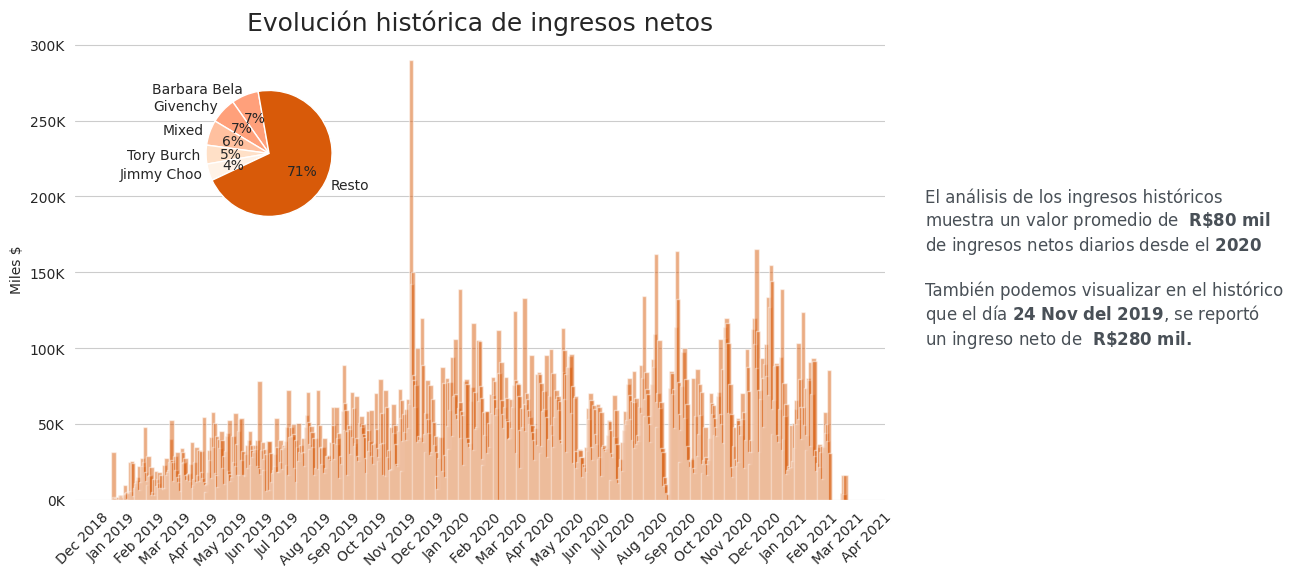

In [50]:
crear_conexion()
query = """
SELECT p.fecha_compra, SUM(ip.valor_total - ip.costo_envio) AS TotalNeto
FROM itens_pedidos  ip
INNER JOIN pedidos  p ON p.pedido_id=ip.pedido_id
GROUP BY p.fecha_compra
ORDER BY fecha_compra ASC
"""
df=pd.read_sql(sql=text(query),con=database.connect())
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

#consulta 2 donde vamos a obtener las marcas más vendidas en un dia especifico (2019-11-24)
query2="""
SELECT p.marca, SUM(ip.cantidad * p.precio) AS ventas_total
FROM itens_pedidos ip
INNER JOIN productos p ON ip.producto_id = p.producto_id
INNER JOIN pedidos pe ON ip.pedido_id = pe.pedido_id
WHERE strftime('%Y-%m-%d', pe.fecha_compra) = '2019-11-24'
GROUP BY marca
ORDER BY ventas_total DESC
"""
df2=pd.read_sql(sql=text(query2),con=database.connect())
database.dispose()

# Crear la figura y los objetos de ejes
fig, ax = plt.subplots(figsize=(12, 6))
# Dibujar el gráfico de barras
ax.bar(df.fecha_compra, df.TotalNeto, width=5, alpha=0.5, color='#D85A09')
# Formatear el eje X
ax.xaxis.set_major_locator(mdates.DayLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Formatear los números en el eje y como "100k"
formatter = FuncFormatter(lambda x, _: f'{x / 1000:.0f}K')
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Miles $')
# Agregar título al gráfico
plt.title('Evolución histórica de ingresos netos', fontsize=18)
# Rotar el eje x a 45 grados
plt.xticks(rotation=45)
# Agregar espacio a la derecha del gráfico para el texto
fig.subplots_adjust(right=0.8)  # Ajustar según el espacio deseado
# Obtener límites del eje x y eje y
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()

# Agregar el texto al lado del gráfico
conclusion_text=(
    "El análisis de los ingresos históricos\n"
    "muestra un valor promedio de  $\\bf{R \\$80\\ mil}$ \n"
    "de ingresos netos diarios desde el $\\bf{2020}$ \n\n"
    "También podemos visualizar en el histórico \n"
    "que el día $\\bf{24\\ Nov\\ del\\ 2019}$, se reportó\n"
    "un ingreso neto de  $\\bf{R \\$280\\ mil}.$ "
)

ax.text(x_limits[1] + (x_limits[1] - x_limits[0]) * 0.05,(y_limits[0] + y_limits[1]) / 2, conclusion_text, fontsize=12, color='#495057', va='center', ha='left')
# Mostrar líneas horizontales en el grid
ax.grid(axis='y', linestyle='-', linewidth=0.8)

# Tomar las primeras 5 marcas y sumar el resto de las ventas
top_5_marcas = df2.head(5)
resto_ventas = df2.iloc[5:]['ventas_total'].sum()
# Crear un nuevo DataFrame con las primeras 5 marcas y el resto de las ventas
df_pizza = pd.concat([top_5_marcas, pd.DataFrame({'marca': ['Resto'], 'ventas_total': [resto_ventas]})])
# Calcular los porcentajes de las ventas para cada marca
porcentajes = (df_pizza['ventas_total'] / df_pizza['ventas_total'].sum() * 100)
# Crear un degradado de marrón comenzando con el color #D85A09 y yendo hacia tonos más claros
colors = ['#FFA07b', '#FFA07A', '#FFC09F', '#FFE0C7', '#FFF2E6', '#D85A09']

# Dibujar el gráfico de pastel superpuesto
pie_ax = ax.inset_axes([0.09, 0.6, 0.3, 0.3])  # Posición y tamaño del gráfico de pastel
pie_ax.pie(porcentajes, labels=df_pizza['marca'], autopct='%1.0f%%', startangle=100, colors=colors)
pie_ax.axis('equal')

# Añadiremos lineas de cuadricula solo en el eje X
ax.grid(axis='x')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()


##**Pregunta 3: ¿Cuáles son los ingresos netos por vendedor por año?**

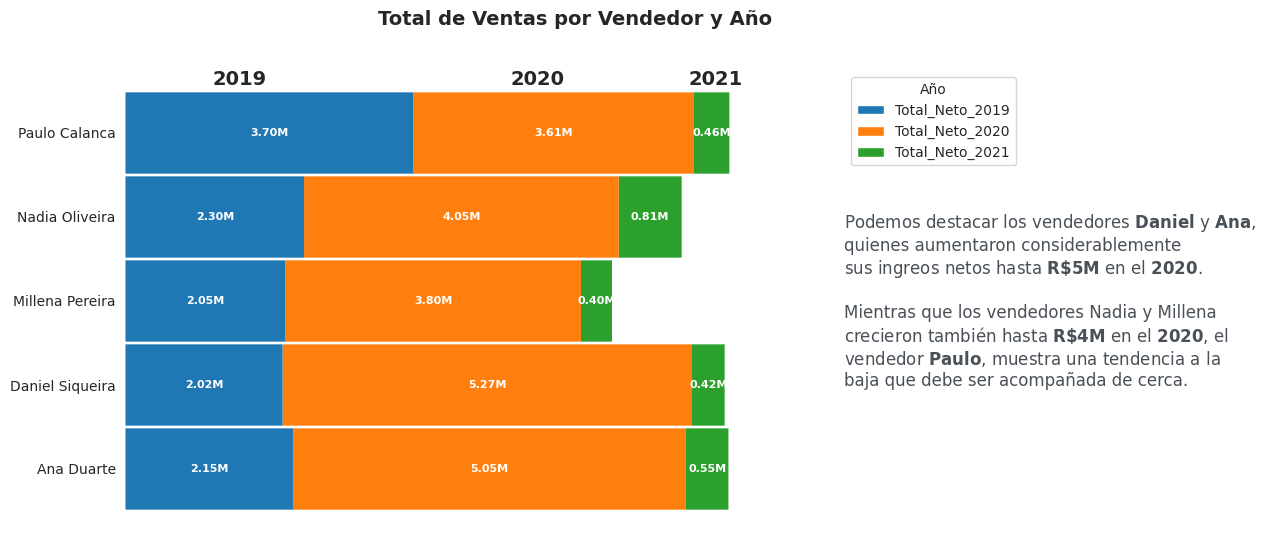

In [51]:
crear_conexion()
query = """
SELECT v.nombre_vendedor,
SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2019' THEN p.total - i.costo_envio ELSE 0 END) AS Total_Neto_2019,
SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2020' THEN p.total - i.costo_envio ELSE 0 END) AS Total_Neto_2020,
SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2021' THEN p.total - i.costo_envio ELSE 0 END) AS Total_Neto_2021
FROM pedidos p
INNER JOIN itens_pedidos i ON p.pedido_id = i.pedido_id
INNER JOIN vendedores v ON p.vendedor_id = v.vendedor_id
GROUP BY v.nombre_vendedor

"""
df=pd.read_sql(sql=text(query),con=database.connect(), index_col="nombre_vendedor")
database.dispose()

# Crear la figura y los ejes
fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(12, 6))

# Graficar los datos apilados
ax = df.plot.barh(stacked=True, width=1, legend=False, ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c']
)

# Agregar etiquetas a las barras
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    label = f'{width / 1e6:.2f}M'  # Convertir a millones y formatear el texto
    ax.text(x + width/2, y + height/2, label, ha='center', va='center', fontsize=8, color='white', fontweight='bold')

# Personalizar el diseño de las barras
new_patches = []
for patch in reversed(ax.patches):
    bb = patch.get_bbox()
    color = patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin), abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.0040,rounding_size=0.015",
                            ec="none", fc=color, mutation_aspect=4)
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax.add_patch(patch)

# Configurar las etiquetas de los ejes
ax.set_xlabel('Ventas en millones')
ax.set_ylabel('Vendedor')

# Ajustar el espacio entre los subplots
plt.subplots_adjust(wspace=0.2)

# Configurar el texto de la conclusión
conclusion_text=(
    "Podemos destacar los vendedores $\\bf{Daniel}$ y $\\bf{Ana}$,\n"
    "quienes aumentaron considerablemente\n"
    "sus ingreos netos hasta $\\bf{R \\$5M}$ en el $\\bf{2020}$.\n\n"

    "Mientras que los vendedores Nadia y Millena\n"
    "crecieron también hasta $\\bf{R \\$4M}$ en el $\\bf{2020}$, el\n"
    "vendedor $\\bf{Paulo}$, muestra una tendencia a la\n"
    "baja que debe ser acompañada de cerca."
)
ax2.text(0, 0.5, conclusion_text, fontsize=12, color='#495057', va='center', ha='left')
ax2.axis('off')

# Agregar título al gráfico
plt.suptitle('Total de Ventas por Vendedor y Año', fontsize=14, fontweight='bold')

# Eliminar el cuadro delimitador alrededor del gráfico
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Crear leyenda para el segundo subplot
handles, labels = ax.get_legend_handles_labels()
ax2.legend(handles, labels, loc='upper left', title='Año')

# Agregar texto "2019" y "2020" en negrita encima del gráfico
ax.text(0.18, 0.98, '2019', ha='center', va='center', fontsize=14, fontweight='bold', transform=ax.transAxes)
ax.text(0.65, 0.98, '2020', ha='center', va='center', fontsize=14, fontweight='bold', transform=ax.transAxes)
ax.text(0.93, 0.98, '2021', ha='center', va='center', fontsize=14, fontweight='bold', transform=ax.transAxes)

# Mostrar el gráfico
plt.show()


##**Pregunta 4: ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?**

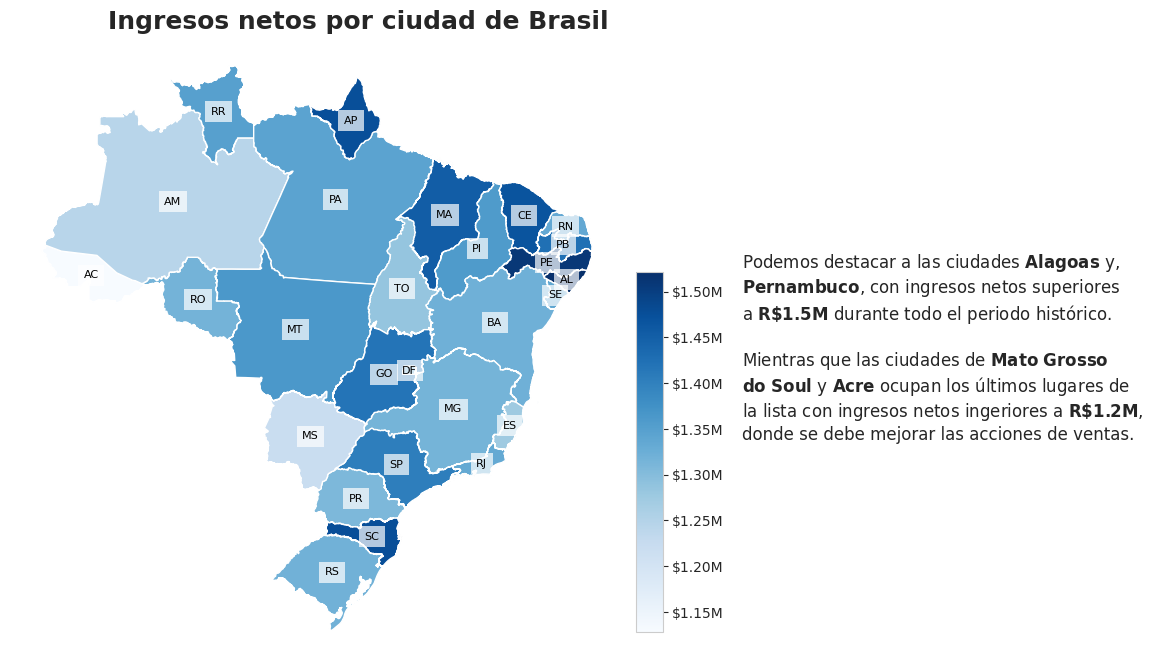

In [52]:
crear_conexion()
query = """
SELECT i.ciudad, SUM(p.total-i.costo_envio) AS ingresos_netos, SUBSTRING(ciudad,4,2) AS abbrev_state
FROM pedidos p
INNER JOIN itens_pedidos i ON p.pedido_id = i.pedido_id
GROUP BY i.ciudad
"""
df=pd.read_sql(sql=text(query),con=database.connect())
database.dispose()
# Leer los límites de los estados de Brasil
br_uf = geobr.read_state(code_state="all")
# Hacer un merge con tu DataFrame original
br_uf_d = pd.merge(br_uf, df, left_on="abbrev_state", right_on="abbrev_state")
# Quedarte con las columnas necesarias para el gráfico
br_uf_d = br_uf_d[["abbrev_state", "geometry", "ingresos_netos"]]


# Crear la figura y los objetos de ejes
fig, ax = plt.subplots(figsize=(9, 9))
ax=br_uf_d.plot(ax=ax,column="ingresos_netos",cmap="Blues")
cax = fig.add_axes([0.82, 0.18,0.03,0.40,])
sm = plt.cm.ScalarMappable(
    cmap="Blues",                                       # Usa o mesmo cmap do mapa
    norm=plt.Normalize(
        vmin=br_uf_d["ingresos_netos"].min(),  # Valor mínimo
        vmax=br_uf_d["ingresos_netos"].max(),  # Valor máximo
    ),
)
fig.colorbar( sm,
    cax=cax,
    # Formata a escala do Colorbar
    format=ticker.FuncFormatter(lambda x, _: f'${x / 1000000:.2f}M'),)

# Añadir nombres de ciudades
for idx, row in br_uf_d.iterrows():
    ax.annotate(row["abbrev_state"],
                (row["geometry"].centroid.x, row["geometry"].centroid.y),
                fontsize=8,
                ha='center',
                va='center',
                color='black',
                backgroundcolor='white',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Eliminar etiquetas y ticks del eje y
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', length=0)
ax.tick_params(axis='y', which='both', length=0)
ax.set_yticklabels([])
# Eliminar el título del eje x
ax.set_xlabel('')
# Eliminar el título del eje y
ax.set_ylabel('')
# Agregar espacio a la derecha del gráfico para el texto "lorem ipsum"
fig.subplots_adjust(right=0.9)  # Ajusta el valor según el espacio deseado

#AGREGA EL TITULO
ax.set_title("Ingresos netos por ciudad de Brasil",fontdict={"fontsize": 18},fontweight='bold')
# Obtener límites del eje x y eje y
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()

conclusion_text=(
    "Podemos destacar a las ciudades $\\bf{Alagoas}$ y,\n"
    "$\\bf{Pernambuco}$, con ingresos netos superiores\n"
    "a $\\bf{R \\$1.5M}$ durante todo el periodo histórico.\n\n"

    "Mientras que las ciudades de $\\bf{Mato\\ Grosso}$\n"
    "$\\bf{do\\ Soul}$ y $\\bf{Acre}$ ocupan los últimos lugares de\n"
    "la lista con ingresos netos ingeriores a $\\bf{R \\$1.2M}$,\n"
    "donde se debe mejorar las acciones de ventas."
    )
# Añadir texto adicional debajo de la línea
ax.text(x_limits[1] + (x_limits[1] - x_limits[0]) * 0.05,
         (y_limits[0] + y_limits[1]) / 2,
         conclusion_text,
         fontsize=12,
         ha='left',  # Alinear a la izquierda horizontalmente
         va='center')  # Centrar verticalmente


# Quitar la cuadrícula del fondo
ax.grid(False)
# Quitar el cuadro delimitador
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

##**Pregunta 5: ¿Cuáles son las vendedores que manejan mejor los costos de envío?**

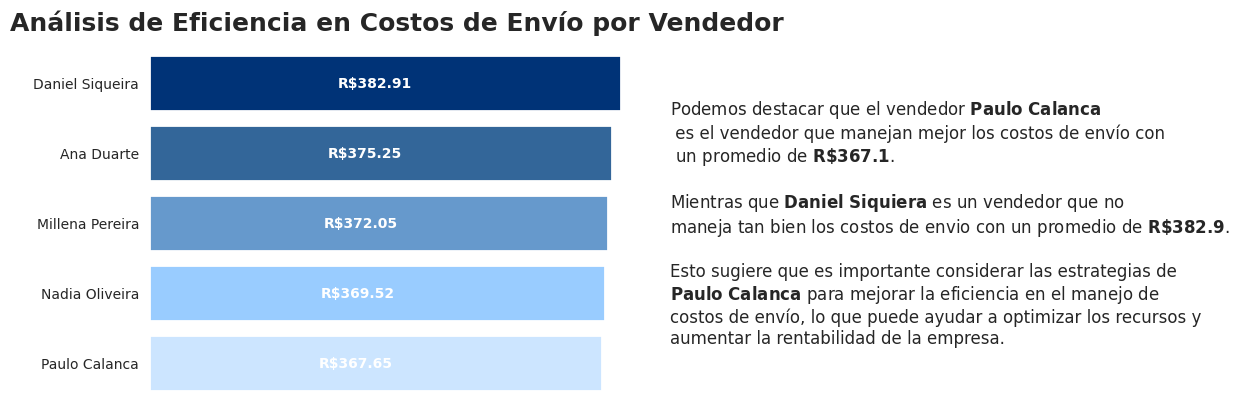

In [98]:
crear_conexion()
query = """
SELECT v.nombre_vendedor, AVG(i.costo_envio) AS promedio_costo_envio
FROM itens_pedidos i
JOIN pedidos p ON i.pedido_id = p.pedido_id
JOIN vendedores v ON p.vendedor_id = v.vendedor_id
GROUP BY v.nombre_vendedor
ORDER BY promedio_costo_envio ASC;
"""
df=pd.read_sql(sql=text(query),con=database.connect())
database.dispose()
# Crear una lista de colores para el degradado de mayor a menor
colors =['#CCE5FF', '#99CCFF', '#6699CC', '#336699', '#003377']
# Crear la figura y el eje
fig, ax = plt.subplots()
# Crear el gráfico de barras horizontales con degradado de color y bordes redondeados
bars = ax.barh(df['nombre_vendedor'], df['promedio_costo_envio'], color=colors, linewidth=2, zorder=0)

# Agregar etiquetas dentro de cada barra con dos decimales y '$R'
for bar in bars:
    width = bar.get_width()
    ax.text(width-200, bar.get_y() + bar.get_height()/2, f'R${width:.2f}',
            va='center', ha='center', color='white', fontsize=10, fontweight='bold', zorder=6)

# Obtener límites del eje x y eje y
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()

conclusion_text=(
    "Podemos destacar que el vendedor $\\bf{Paulo\\ Calanca}$\n "
    "es el vendedor que manejan mejor los costos de envío con \n "
    "un promedio de $\\bf{R\\$367.1}$.\n\n"

    "Mientras que $\\bf{Daniel\\ Siquiera}$ es un vendedor que no \n"
    "maneja tan bien los costos de envio con un promedio de $\\bf{R\\$382.9}$.\n\n"
    "Esto sugiere que es importante considerar las estrategias de \n"
    "$\\bf{Paulo\\ Calanca}$ para mejorar la eficiencia en el manejo de  \n"
    "costos de envío, lo que puede ayudar a optimizar los recursos y \n"
    "aumentar la rentabilidad de la empresa."
    )
# Añadir texto adicional debajo de la línea
ax.text(x_limits[1] + (x_limits[1] - x_limits[0]) * 0.05,
         (y_limits[0] + y_limits[1]) / 2,
         conclusion_text,
         fontsize=12,
         ha='left',  # Alinear a la izquierda horizontalmente
         va='center')  # Centrar verticalmente

ax.set_title('Análisis de Eficiencia en Costos de Envío por Vendedor', fontweight='bold', fontsize=18)

# Quitar la cuadrícula del fondo
ax.grid(False)
# Quitar el cuadro delimitador
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])

# Mostrar la gráfica
plt.show()


##**Pregunta 5: ¿Cuáles son el Top 5 de las marcas más vendidas históricamente?**

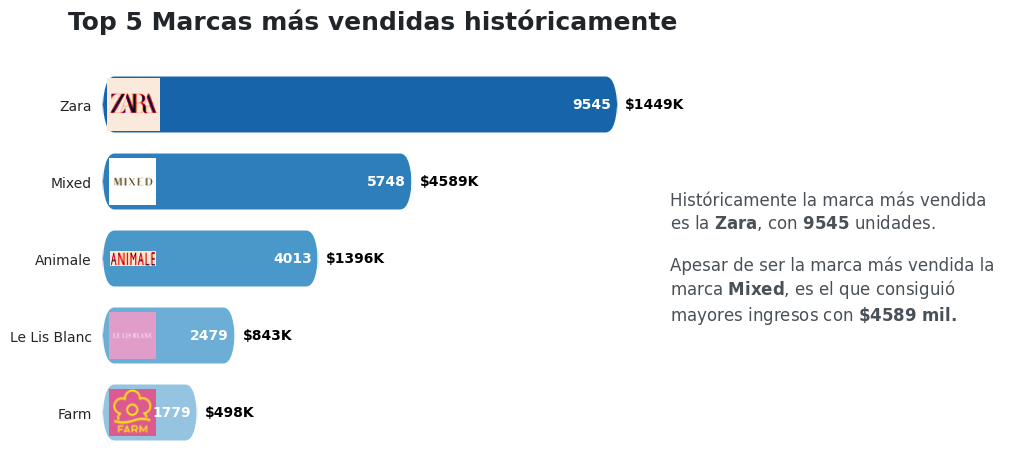

In [155]:
crear_conexion()
query = """
SELECT p.marca,SUM(ip.valor_total) AS total_vendido,SUM(ip.cantidad) AS cantidad_vendida
FROM itens_pedidos  ip
INNER JOIN productos  p ON p.producto_id=ip.producto_id
GROUP BY p.marca
ORDER BY cantidad_vendida DESC
LIMIT 5
"""
df=pd.read_sql(sql=text(query),con=database.connect())
database.dispose()
df['total_vendido'] = (df['total_vendido']/1000).apply(lambda x: f'${x:.0f}K')
image_path = [
    'https://github.com/JhonatanRC03/Robot_Trading/blob/main/zara%20(3).png?raw=true',
    'https://github.com/JhonatanRC03/Robot_Trading/blob/main/mixed%20(1).png?raw=true',
    'https://github.com/JhonatanRC03/Robot_Trading/blob/main/animale%20(1).png?raw=true',
    'https://github.com/JhonatanRC03/Robot_Trading/blob/main/le_lis%20(1).png?raw=true',
    'https://github.com/JhonatanRC03/Robot_Trading/blob/main/farm%20(1).png?raw=true']
plt.subplots(figsize=(7, 5))
colores_azules = plt.cm.Blues_r(np.linspace(0.2,0.6,len(df)))
ax = sns.barplot(x=df.cantidad_vendida/300, y=df.marca, orient='h', joinstyle='bevel')

new_patches = []
for patch, color, marca, cantidad_vendida, total_vendido, image_path in zip(ax.patches, colores_azules, df['marca'],df['cantidad_vendida'],df['total_vendido'],image_path):
    bb = patch.get_bbox()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.05,rounding_size=0.73",
                            ec="none", fc=color,
                            mutation_aspect=0.73
                            )
    patch.remove()
    new_patches.append(p_bbox)

    #Añadir imagen dentro de la barra
    response = requests.get(image_path)
    image = plt.imread(BytesIO(response.content))
    imagebox = OffsetImage(image, zoom=0.75)
    ab = AnnotationBbox(imagebox, xy=(1.9, patch.get_y() + patch.get_height()/2),
                        xybox=(0, 0), xycoords='data', boxcoords="offset points",
                        pad=0, arrowprops=dict(arrowstyle='-', color='none'),
                        bboxprops=dict(facecolor='none',edgecolor='none'))
    ax.add_artist(ab)

    # Añadir texto (cantidad_vendida) al lado derecho de la barra
    ax.annotate(f'{cantidad_vendida}', xy=(patch.get_width(), patch.get_y() + patch.get_height ()/2),
    xytext=(-5, 0), textcoords='offset points',
    arrowprops=dict (arrowstyle='-', color='none'),
    color='white', fontweight='bold', fontsize=10, ha='right', va='center',
    xycoords='data',
    bbox=dict (facecolor='none', edgecolor='none', pad=0),
    annotation_clip=False)

        # Añadir texto (total_vendido) al lado derecho de la barra
    ax.annotate(f'{total_vendido}', xy=(patch.get_width(), patch.get_y() + patch.get_height ()/2),
    xytext=(5, 0), textcoords='offset points',
    arrowprops=dict(arrowstyle='-', color='none'),
    color='black', fontweight='bold', fontsize=10, ha='left', va='center',
    xycoords='data',
    bbox=dict (facecolor='none', edgecolor='none', pad=0),
    annotation_clip=False)

for patch in new_patches:
    ax.add_patch (patch)

conclusion_text=(
    "Históricamente la marca más vendida\n"
    "es la $\\bf{Zara}$, con $\\bf{9545}$ unidades.\n\n"
    "Apesar de ser la marca más vendida la \n"
   "marca $\\bf{Mixed}$, es el que consiguió\n"
    "mayores ingresos con $\\bf{\\$4589\\ mil}.$ "
)

ax. text(35, 2, conclusion_text, fontsize=12, color='#495057', va= 'center', ha='left')

# Personalizando el gráfico
ax.set_title('Top 5 Marcas más vendidas históricamente\n', loc='center', fontsize=18, color='#212529', fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.yaxis.grid(False)
ax.xaxis.grid (False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()